In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../train.csv')
df.head(2)

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

### Function that decodes rle (for this comp) to a binary mask

In [3]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

simple test

189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1


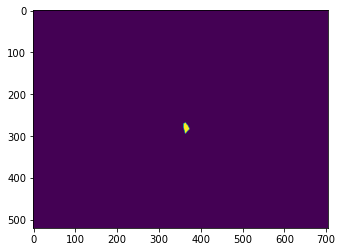

In [4]:
rle = df.loc[1, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));

### Build .json file

In [5]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

def annotate(idx, row, cat_ids):
        mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
        c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
        c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
        area = maskUtils.area(c_rle).item() # calculating the area
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
        return annotation
    
def coco_structure(df, workers = 4):
    
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

### Decode the whole df

In [6]:
import json,itertools
root = coco_structure(df)

  0%|          | 0/73585 [00:00<?, ?it/s]

In [ ]:
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

### KFlod

In [6]:
from sklearn.model_selection import StratifiedKFold

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['cell_type']), 1):
    df.loc[val_idx, 'fold'] = fold
df['fold'] = df['fold'].astype(np.uint8)

In [45]:
# df['fold']

In [46]:
df.to_csv(f'./train_folds.csv', index=False)

In [47]:
# df_train = pd.read_csv('../train.csv')
# df_train_folds = pd.read_csv(f'./train_folds.csv')
# df_train = pd.merge(df_train, df_train_folds, how='inner', on='id')
df_train = pd.read_csv('./train_folds.csv')

In [48]:
df_train

id                                         annotation  width  \
0      0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1      0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2      0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3      0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4      0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
...             ...                                                ...    ...   
73580  ffdb3cc02eef  3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...    704   
73581  ffdb3cc02eef  341585 2 342287 5 342988 10 343690 13 344394 1...    704   
73582  ffdb3cc02eef  47788 3 48490 7 49192 11 49896 13 50599 14 513...    704   
73583  ffdb3cc02eef  333290 1 333993 2 334696 4 335399 5 336102 6 3...    704   
73584  ffdb3cc02eef  249775 2 250477 6 251180 8 251882 11 252585 12...    704   

       height cell_type plate_time sample_date  \
0         520    shsy5y  11h30m00s  2019-06-16   
1         520    shsy5y  11h30m00s  2019-06-16   
2         520    shsy5y  11h30m00s  2019-06-16   
3         520    shsy5y  11h30m00s  2019-06-16   
4         520    shsy5y  11h30m00s  2019-06-16   
...       ...       ...        ...         ...   
73580     520      cort  11h59m00s  2020-11-01   
73581     520      cort  11h59m00s  2020-11-01   
73582     520      cort  11h59m00s  2020-11-01   
73583     520      cort  11h59m00s  2020-11-01   
73584     520      cort  11h59m00s  2020-11-01   

                                sample_id elapsed_timedelta  fold  
0      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     4  
1      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     3  
2      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     3  
3      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     2  
4      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     3  
...                                   ...               ...   ...  
73580   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     4  
73581   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     4  
73582   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     5  
73583   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     5  
73584   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     4  

[73585 rows x 10 columns]

In [49]:
train_folds = []
val_folds = []
for i in range(1, 6):
    train_folds.append(df_train[df_train['fold'] != i])
    val_folds.append(df_train[df_train['fold'] == i])

In [50]:
len(train_folds[0])

58868

In [51]:
import json
import itertools
train_fold_json = [coco_structure(fold) for fold in train_folds]
val_fold_json = [coco_structure(fold) for fold in val_folds]

  0%|          | 0/58868 [00:00<?, ?it/s]

  0%|          | 0/58868 [00:00<?, ?it/s]

  0%|          | 0/58868 [00:00<?, ?it/s]

  0%|          | 0/58868 [00:00<?, ?it/s]

  0%|          | 0/58868 [00:00<?, ?it/s]

  0%|          | 0/14717 [00:00<?, ?it/s]

  0%|          | 0/14717 [00:00<?, ?it/s]

  0%|          | 0/14717 [00:00<?, ?it/s]

  0%|          | 0/14717 [00:00<?, ?it/s]

  0%|          | 0/14717 [00:00<?, ?it/s]

NameError: name 'coco_json' is not defined

In [52]:
for idx, (train_fold, val_fold) in enumerate(zip(train_fold_json, val_fold_json)):
    with open(f'./fold_{idx+1}_train.json', 'w+', encoding='utf-8') as f:
        json.dump(train_fold, f, ensure_ascii=True, indent=4)
    with open(f'./fold_{idx+1}_val.json', 'w+', encoding='utf-8') as f:
        json.dump(val_fold, f, ensure_ascii=True, indent=4)

### Check

In [9]:
df.columns

Index(['id', 'annotation', 'width', 'height', 'cell_type', 'plate_time',
       'sample_date', 'sample_id', 'elapsed_timedelta'],
      dtype='object')

In [11]:
df[df['id']=='d1d1ca1bfb8a']

id                                         annotation  width  \
61521  d1d1ca1bfb8a  293072 5 293775 8 294477 11 295180 13 295884 1...    704   
61522  d1d1ca1bfb8a  44 17 747 19 1451 19 2155 19 2860 18 3564 18 4...    704   
61523  d1d1ca1bfb8a  180691 8 181389 16 182093 17 182797 17 183501 ...    704   
61524  d1d1ca1bfb8a  163570 2 164272 5 164965 16 165668 18 166370 2...    704   
61525  d1d1ca1bfb8a  137977 4 138679 9 139382 11 140086 11 140790 1...    704   
61526  d1d1ca1bfb8a  167948 8 168651 10 169354 12 170057 15 170760 ...    704   
61527  d1d1ca1bfb8a  273672 1 274374 4 275076 7 275773 14 276474 17...    704   
61528  d1d1ca1bfb8a  81776 3 82479 7 83183 7 83886 7 84590 7 85293 ...    704   
61529  d1d1ca1bfb8a  244390 1 245092 5 245794 8 246498 10 247203 10...    704   
61530  d1d1ca1bfb8a  312475 3 313177 7 313881 9 314584 11 315288 11...    704   
61531  d1d1ca1bfb8a  60693 2 61395 8 62097 12 62800 13 63504 14 642...    704   
61532  d1d1ca1bfb8a  205869 3 206569 8 207270 11 207974 12 208678 1...    704   
61533  d1d1ca1bfb8a  358250 2 358953 5 359656 8 360358 12 361061 13...    704   
61534  d1d1ca1bfb8a  214807 4 215507 9 216211 9 216915 10 217618 12...    704   
61535  d1d1ca1bfb8a  332069 2 332770 7 333472 11 334176 12 334880 1...    704   
61536  d1d1ca1bfb8a  356221 4 356920 9 357623 10 358325 12 359028 1...    704   
61537  d1d1ca1bfb8a  219836 8 220539 11 221242 12 221946 12 222650 ...    704   
61538  d1d1ca1bfb8a  350693 2 351396 7 352100 11 352803 14 353507 1...    704   
61539  d1d1ca1bfb8a  347436 4 348139 7 348841 11 349544 14 350248 1...    704   
61540  d1d1ca1bfb8a  118357 5 119060 10 119763 12 120466 14 121169 ...    704   
61541  d1d1ca1bfb8a  179452 2 180154 5 180855 8 181557 11 182260 13...    704   
61542  d1d1ca1bfb8a  333760 3 334464 8 335167 11 335871 12 336575 1...    704   
61543  d1d1ca1bfb8a  107447 4 108150 5 108853 7 109556 8 110259 9 1...    704   
61544  d1d1ca1bfb8a  208552 5 209255 8 209957 12 210660 14 211364 1...    704   
61545  d1d1ca1bfb8a  213534 2 214234 9 214937 12 215641 12 216344 1...    704   
61546  d1d1ca1bfb8a  73600 4 74304 10 75007 15 75711 17 76415 18 77...    704   
61547  d1d1ca1bfb8a  131383 8 132086 10 132790 10 133493 11 134197 ...    704   
61548  d1d1ca1bfb8a  207260 3 207961 8 208663 12 209366 15 210070 1...    704   
61549  d1d1ca1bfb8a  341796 3 342497 6 343200 8 343903 9 344607 10 ...    704   
61550  d1d1ca1bfb8a  251682 2 252385 6 253087 10 253790 14 254493 1...    704   
61551  d1d1ca1bfb8a  198407 5 199109 8 199812 9 200515 11 201219 11...    704   
61552  d1d1ca1bfb8a  253901 2 254603 6 255305 9 256008 10 256712 11...    704   
61553  d1d1ca1bfb8a  197312 3 198016 9 198720 12 199423 14 200127 1...    704   
61554  d1d1ca1bfb8a  335852 3 336555 6 337257 9 337960 11 338662 13...    704   
61555  d1d1ca1bfb8a  50458 2 51161 5 51863 8 52566 10 53269 11 5397...    704   
61556  d1d1ca1bfb8a  40801 4 41501 9 42204 10 42908 11 43611 12 443...    704   
61557  d1d1ca1bfb8a  295614 4 296316 9 297020 9 297723 11 298427 11...    704   
61558  d1d1ca1bfb8a  8036 4 8739 8 9442 11 10144 14 10848 14 11551 ...    704   
61559  d1d1ca1bfb8a  38435 6 39138 9 39841 12 40544 15 41247 17 419...    704   
61560  d1d1ca1bfb8a  124040 2 124742 7 125446 9 126151 9 126855 9 1...    704   

       height cell_type plate_time sample_date  \
61521     520      cort  07h30m00s  2020-11-05   
61522     520      cort  07h30m00s  2020-11-05   
61523     520      cort  07h30m00s  2020-11-05   
61524     520      cort  07h30m00s  2020-11-05   
61525     520      cort  07h30m00s  2020-11-05   
61526     520      cort  07h30m00s  2020-11-05   
61527     520      cort  07h30m00s  2020-11-05   
61528     520      cort  07h30m00s  2020-11-05   
61529     520      cort  07h30m00s  2020-11-05   
61530     520      cort  07h30m00s  2020-11-05   
61531     520      cort  07h30m00s  2020-11-05   
61532     520      cort  07h30m00s  2020-11-05   
61533     520      cort  07h30m00s  2020-11-0

In [13]:
# "categories": [
#         {
#             "name": "shsy5y",
#             "id": 1
#         },
#         {
#             "name": "astro",
#             "id": 2
#         },
#         {
#             "name": "cort",
#             "id": 3
#         }
#     ]

In [7]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [8]:
dataDir=Path('../')
annFile = Path('./annotations_train.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


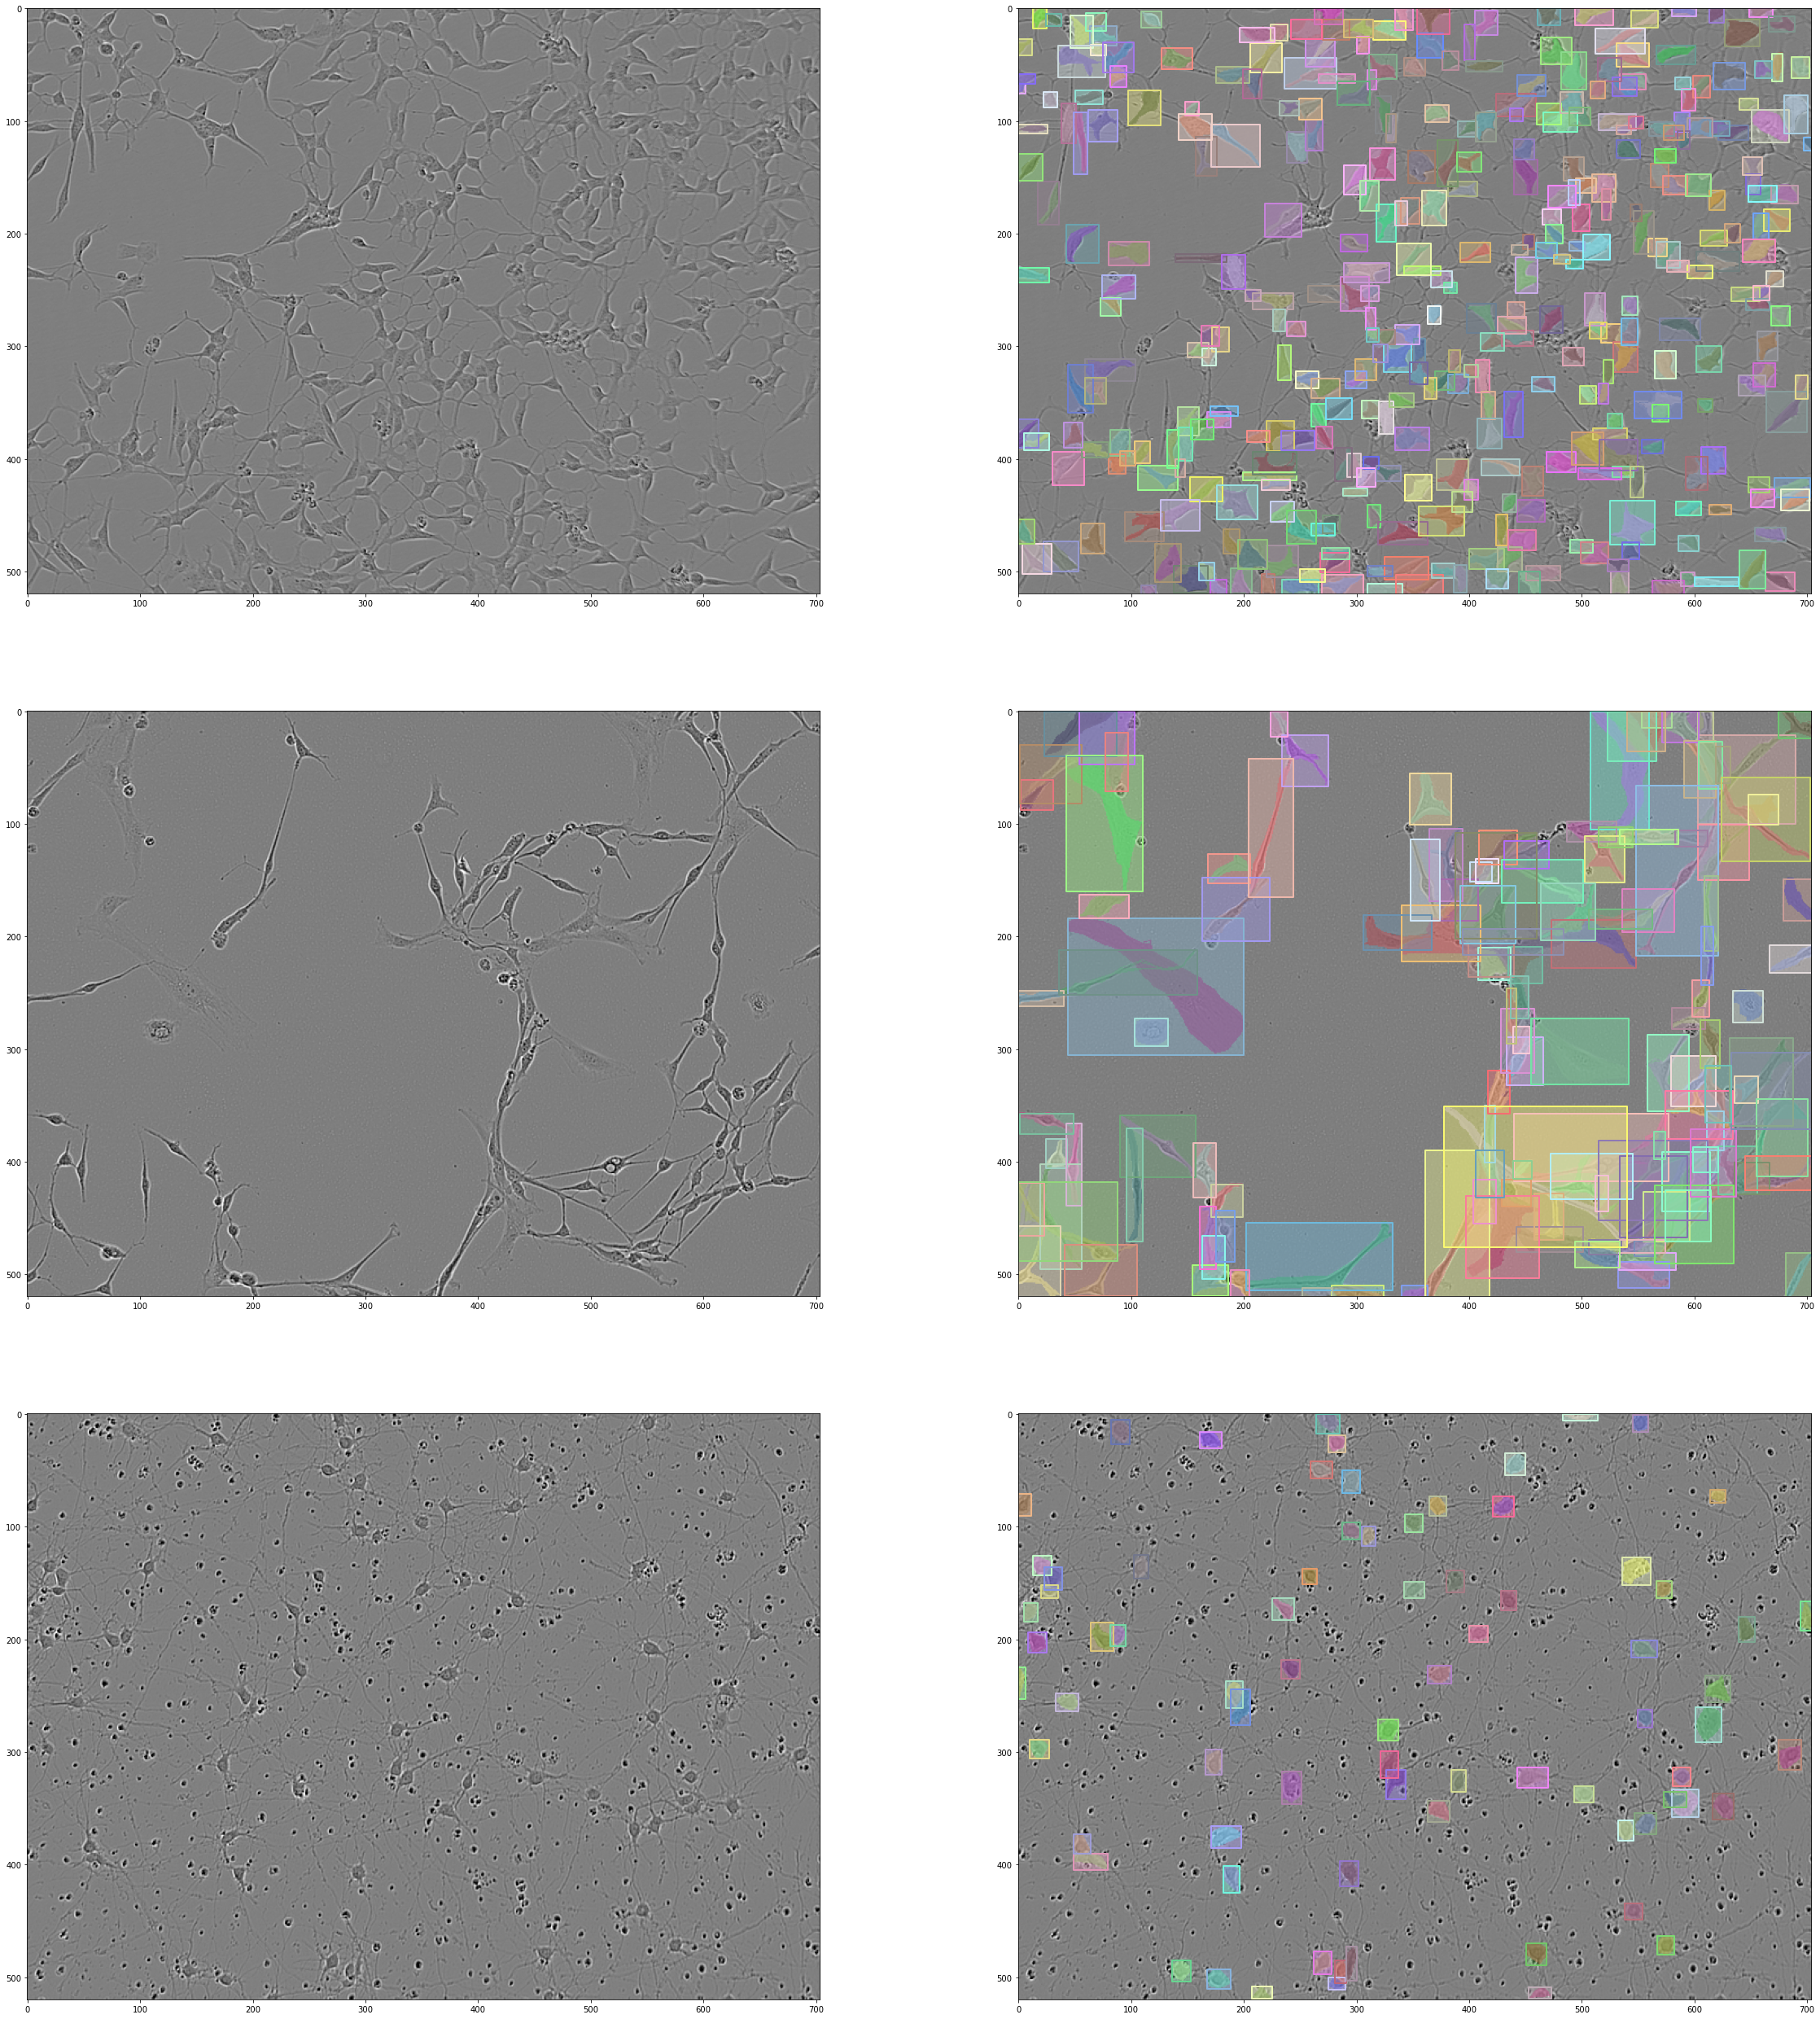

In [9]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I, cmap='gray')
    ax[1].imshow(I, cmap='gray')
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)